In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import seaborn as sns 
from datetime import datetime
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, classification_report
from sklearn.impute import KNNImputer
from itertools import product

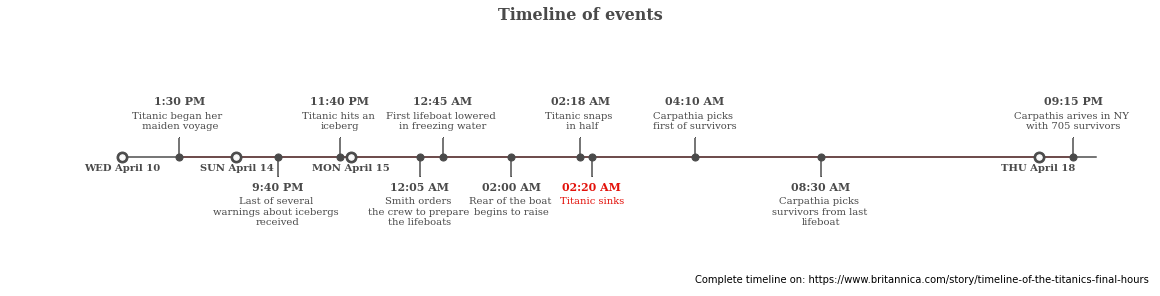

In [2]:

tl_dates = [
    "WED April 10",
    "SUN April 14",
    "MON April 15",
    "THU April 18"
]

tl_x = [1, 2, 3, 9]

tl_sub_x = [1.5, 2.36, 2.9, 3.6, 3.8, 4.4, 5, 5.1, 6, 7.1, 9.3]
tl_sub_times = [
    "1:30 PM",
    "9:40 PM",
    "11:40 PM",
    "12:05 AM",
    "12:45 AM",
    "02:00 AM",
    "02:18 AM",
    "02:20 AM",
    "04:10 AM",
    "08:30 AM",
    "09:15 PM",
]

tl_text = [
    "Titanic began her \n maiden voyage",
    "Last of several \nwarnings about icebergs \nreceived",
    "Titanic hits an \niceberg", 
    "Smith orders \nthe crew to prepare \nthe lifeboats",
    "First lifeboat lowered \nin freezing water",
    "Rear of the boat \nbegins to raise",
    "Titanic snaps \n in half",
    "Titanic sinks",
    "Carpathia picks \nfirst of survivors",
    "Carpathia picks \nsurvivors from last \nlifeboat",
    "Carpathis arives in NY \nwith 705 survivors"
]

# Set figure & Axes
fig, ax = plt.subplots(figsize=(16, 4), constrained_layout=True)
ax.set_ylim(-2, 2)
ax.set_xlim(0, 10)


# Timeline : line
ax.axhline(0, xmin=0.1, xmax=0.95, c='#4a4a4a', zorder=1)
# Timeline : Date Points
ax.scatter(tl_x, np.zeros(len(tl_x)), s=120, c='#4a4a4a', zorder=2)
ax.scatter(tl_x, np.zeros(len(tl_x)), s=30, c='#fafafa', zorder=3)
# Timeline : Time Points
ax.scatter(tl_sub_x, np.zeros(len(tl_sub_x)), s=50, c='#4a4a4a',zorder=4)

# Date Text
for x, date in zip(tl_x, tl_dates):
    ax.text(x, -0.2, date, ha='center', 
            fontfamily='serif', fontweight='bold',
            color='#4a4a4a')
    

# Stemplot : vertical line
levels = np.zeros(len(tl_sub_x))    
levels[::2] = 0.3
levels[1::2] = -0.3
markerline, stemline, baseline = ax.stem(tl_sub_x, levels, use_line_collection=True)    
plt.setp(baseline, zorder=0)
plt.setp(markerline, marker=',', color='#4a4a4a')
plt.setp(stemline, color='#4a4a4a')

# Text
for idx, x, time, txt in zip(range(1, len(tl_sub_x)+1), tl_sub_x, tl_sub_times, tl_text):
    ax.text(x, 1.3*(idx%2)-0.5, time, ha='center', 
            fontfamily='serif', fontweight='bold',
            color='#4a4a4a' if idx!=8 else '#e3120b', fontsize=11)
    
    ax.text(x, 1.3*(idx%2)-0.6, txt, va='top', ha='center', 
        fontfamily='serif',color='#4a4a4a' if idx!=8 else '#e3120b')

# Spine
for spine in ["left", "top", "right", "bottom"]:
    ax.spines[spine].set_visible(False)

# link to complete timeline
ax.text(6,-1.9, 'Complete timeline on: https://www.britannica.com/story/timeline-of-the-titanics-final-hours', ha='left')

# Ticks    
ax.set_xticks([]) 
ax.set_yticks([]) 

# Title
ax.set_title("Timeline of events", fontweight="bold", fontfamily='serif', fontsize=16, color='#4a4a4a')

plt.show()

### Introduction 

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history. On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

One of the reasons that the shipwreck led to such loss of life was that there were not enough lifeboats for the passengers and crew. Although there was some element of luck involved in surviving the sinking, some groups of people were more likely to survive than others, such as women, children, and the upper-class.


For this assignment the Titanic dataset that can also be found on [Kaggle](https://www.kaggle.com/c/titanic/data) is used.  
Goal of this project is to use distance based learners (particularly KNN algorithm) and try to predict of a passenger survived or not.

### Dataset description

1. PassengerId: Unique passenger identification number
2. Survived: Did a passenger survive or not (0 = died, 1 = survived)
3. Pclass: Socio-economic status (1 = 1st; 2 = 2nd; 3 = 3rd)
4. Name: Name of Passenger
5. Sex: Sex of Passenger
6. Age: Passenger Age
7. SibSp: Number of Siblings (brother, sister, stepbrother, stepsister) /Spouses (husband, wife (mistresses and fiancés were ignored)) Aboard
8. Parch: Number of Parents/ Children Aboard (Some children travelled only with a nanny, therefore parch=0 for them.)
9. Ticket: Ticket Number
10. Fare: Passenger Fare
11. Cabin: Cabin
12. Embarked: Port of Embarkation (C = Cherbourg; Q = Queenstown; S = Southampton)


In [3]:
data_path = 'C:/Users/anast/OneDrive/Desktop/MSc/MachineLearning/Assignments/Asgmt4_DistanceBasedLearning/Project 4/'
data_file = 'titanic.csv'
df = pd.read_csv(data_path + data_file)

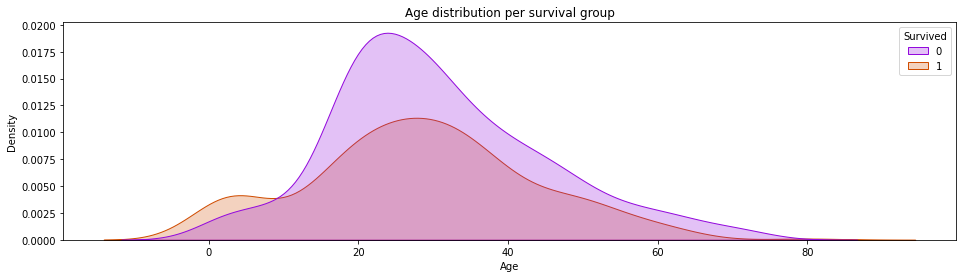

In [4]:
plt.figure(figsize=(16,4))
ageplot = sns.kdeplot(x='Age', data=df, hue='Survived', fill=True, legend=True, palette='gnuplot')
ageplot.title.set_text('Age distribution per survival group')
plt.show()

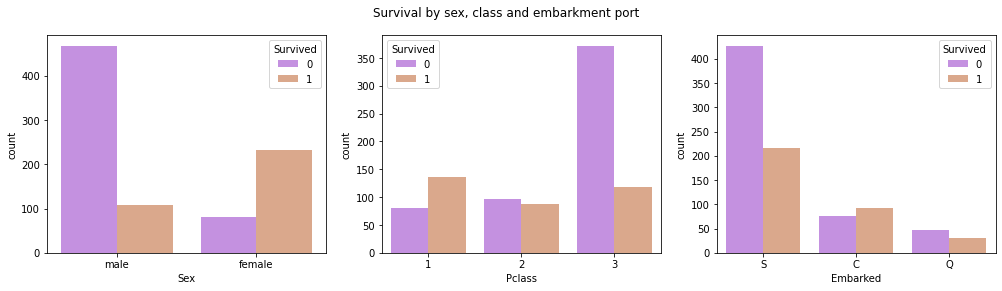

In [5]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(17, 4))
fig.suptitle('Survival by sex, class and embarkment port')

for i, var in enumerate(['Sex', 'Pclass', 'Embarked']):
    sns.countplot(x=var, hue='Survived', palette='gnuplot', alpha=0.5, data=df, ax=axs[i])

### Feature engineering

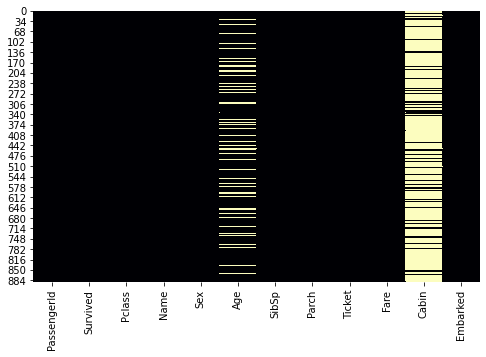

In [6]:
plt.figure(figsize=(8,5))
sns.heatmap(df.isnull(), cmap='magma', cbar = False)
plt.show()

Before starting to impute values, we should split the dataset into train and test set, so that we only make assumptions from train data and use the same assumption on the test set.

In [7]:
X = df.drop(columns = ['Survived'])
y = df['Survived'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_test = pd.DataFrame(X_train).reset_index(drop=True), pd.DataFrame(X_test).reset_index(drop=True)

# adding back survived column to use it in graphs
X_train['Survived'] = list(y_train)

In [8]:
# Sex
sex_encoder = LabelEncoder()
sex_encoder.fit(X_train['Sex'])

X_train['Sex'] = sex_encoder.transform(X_train['Sex'])

X_test['Sex'] = sex_encoder.transform(X_test['Sex'])

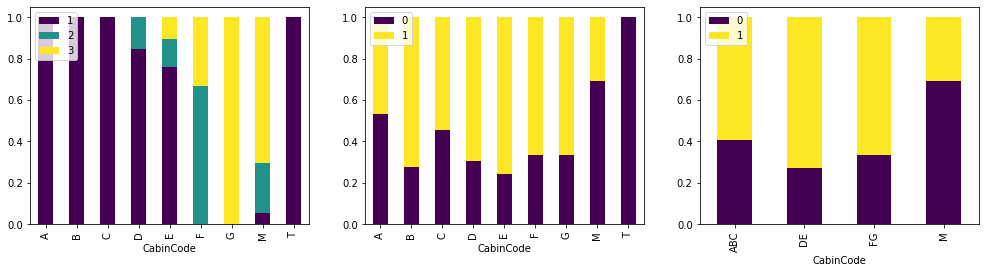

In [9]:
# Cabin

# I will use 'M' on missing cabin information 
X_train['Cabin'].fillna('M', inplace=True)
X_test['Cabin'].fillna('M', inplace=True)

X_train['CabinCode'] = X_train['Cabin'].str.get(0)
X_test['CabinCode'] = X_test['Cabin'].str.get(0)



fig = plt.figure(figsize=(17, 4))

ax1 = plt.subplot(131)
foo1 = X_train[['CabinCode', 'Pclass']].pivot_table(index='CabinCode', columns='Pclass', aggfunc=len, fill_value=0)
foo1 = foo1.apply(lambda x:x/sum(x), axis=1)

pt1 = foo1.plot.bar(stacked=True, legend=False, cmap='viridis', ax=ax1)
patches, labels = pt1.get_legend_handles_labels()
pt1.legend(patches, labels, loc='upper left')


ax2 = plt.subplot(132)
foo2 = X_train[['CabinCode', 'Survived']].pivot_table(index='CabinCode', columns='Survived', aggfunc=len, fill_value=0)
foo2 = foo2.apply(lambda x:x/sum(x), axis=1)

pt2 = foo2.plot.bar(stacked=True, legend=False, cmap='viridis', ax=ax2)
patches, labels = pt2.get_legend_handles_labels()
pt2.legend(patches, labels, loc='upper left')

# Group the CabinCodes in 3 groups 
X_train.loc[X_train['CabinCode'] == 'T', 'CabinCode'] = 'A'
X_train['CabinCode'] = X_train['CabinCode'].replace(['A', 'B', 'C'], 'ABC')
X_train['CabinCode'] = X_train['CabinCode'].replace(['D', 'E'], 'DE')
X_train['CabinCode'] = X_train['CabinCode'].replace(['F', 'G'], 'FG')

X_test.loc[X_test['CabinCode'] == 'T', 'CabinCode'] = 'A'
X_test['CabinCode'] = X_test['CabinCode'].replace(['A', 'B', 'C'], 'ABC')
X_test['CabinCode'] = X_test['CabinCode'].replace(['D', 'E'], 'DE')
X_test['CabinCode'] = X_test['CabinCode'].replace(['F', 'G'], 'FG')

ax3 = plt.subplot(133)
foo3 = X_train[['CabinCode', 'Survived']].pivot_table(index='CabinCode', columns='Survived', aggfunc=len, fill_value=0)
foo3 = foo3.apply(lambda x:x/sum(x), axis=1)

pt3 = foo3.plot.bar(stacked=True, legend=False, cmap='viridis', ax=ax3)
patches, labels = pt3.get_legend_handles_labels()
pt3.legend(patches, labels, loc='upper left')

In [10]:
cabin_mapping = {'ABC': 0, 'DE': 1, 'FG': 2, 'M': 3}

X_train['CabinCode'] = X_train['CabinCode'].map(cabin_mapping)
X_test['CabinCode'] = X_test['CabinCode'].map(cabin_mapping)

X_train = X_train.drop(columns='Cabin')
X_test = X_test.drop(columns='Cabin')

In [11]:
titles = [x[1].split(' ')[1] for x in X_train['Name'].str.split(',')]
X_train['title'] = titles
print('Passenger title distribution:')
print(X_train['title'].value_counts(), '\n')

title_mapping = {'Mr.': 'Mr', 'Mme.': 'Mr',
                 'Master.': 'Master',
                 'Miss.': 'Miss', 'Mlle.': 'Miss', 'Ms.': 'Miss',
                 'Mrs.': 'Mrs',
                 'Dr.': 'Other', 'Rev.': 'Other', 'Major.': 'Other', 'Col.': 'Other', 'Capt.': 'Other',
                 'Don.': 'Royal', 'Jonkheer.': 'Royal', 'Lady.': 'Royal', 'Sir.': 'Royal', 'the': 'Royal',
                 }
X_train.replace({'title': title_mapping}, inplace=True)
print('Title distribution after mapping:')
print(X_train['title'].value_counts())

titles = [x[1].split(' ')[1] if x == x else np.nan for x in X_test['Name'].str.split(',')]
X_test['title'] = titles
X_test.replace({'title': title_mapping}, inplace=True)

Passenger title distribution:
Mr.        419
Miss.      145
Mrs.        96
Master.     35
Dr.          3
Rev.         3
Mlle.        2
Major.       2
Sir.         1
Capt.        1
Ms.          1
Mme.         1
Col.         1
Lady.        1
the          1
Name: title, dtype: int64 

Title distribution after mapping:
Mr        420
Miss      148
Mrs        96
Master     35
Other      10
Royal       3
Name: title, dtype: int64


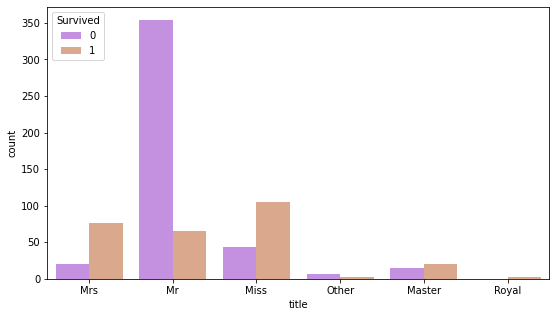

In [12]:
plt.figure(figsize=(9,5))
sns.countplot(x='title', hue='Survived', palette='gnuplot', alpha=0.5, data=X_train)
plt.show()

In [13]:
title_mapping = {'Mr': 1, 'Miss': 2, 'Mrs': 3, 'Other': 4, 'Royal': 5, 'Master': 6}

X_train['Title'] = X_train['title'].map(title_mapping)
X_test['Title'] = X_test['title'].map(title_mapping)

# title is used in imputation, drop it later :)

In [14]:
X_train['FamilySize'] = X_train['SibSp'] + X_train['Parch'] + 1
X_test['FamilySize'] = X_test['SibSp'] + X_test['Parch'] + 1

# X_train['Alone'] = X_train['FamilySize'] == 1
# X_train['Couple'] = X_train['FamilySize'] == 2
# X_train['SmallFamily'] = (X_train['FamilySize'] == 3) | (X_train['FamilySize'] == 4)
# X_train['LargeFamily'] = X_train['FamilySize'] > 4
# X_train.drop('FamilySize', axis=1, inplace=True)

# X_test['Alone'] = X_test['FamilySize'] == 1
# X_test['Couple'] = X_test['FamilySize'] == 2
# X_test['SmallFamily'] = (X_test['FamilySize'] == 3) | (X_test['FamilySize'] == 4)
# X_test['LargeFamily'] = X_test['FamilySize'] > 4
# X_test.drop('FamilySize', axis=1, inplace=True)

# label encode family size
X_train['FamilySize'] = [1 if x<=1 else 2 if x<=4 else 3 for x in X_train['FamilySize']]
X_test['FamilySize'] = [1 if x<=1 else 2 if x<=4 else 3 for x in X_test['FamilySize']]

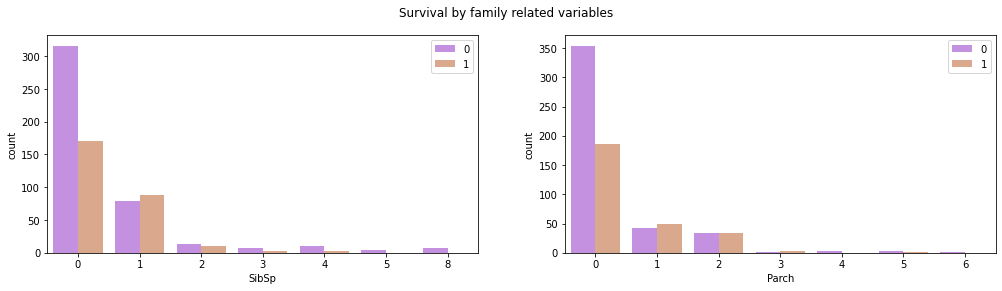

In [15]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(17, 4))
fig.suptitle('Survival by family related variables')

for i, var in enumerate(['SibSp', 'Parch']):
    sns.countplot(x=var, hue='Survived', fill=True, palette='gnuplot', alpha=0.5, data=X_train, ax=axs[i])
    axs[i].legend(loc='upper right')

In [16]:
# Embarked
port_encoder = OneHotEncoder()

X_train['Embarked'] = X_train['Embarked'].fillna(X_train['Embarked'].mode()[0])
X_test['Embarked'] = X_test['Embarked'].fillna(X_train['Embarked'].mode()[0])

port_encoder.fit(X_train['Embarked'].unique().reshape(-1,1))

port_oh_train = port_encoder.transform(X_train['Embarked'].values.reshape(-1,1)).toarray()
port_oh_train = pd.DataFrame(data=port_oh_train, columns=port_encoder.get_feature_names(['Embarked']))
X_train = pd.concat([X_train, port_oh_train], axis=1)
X_train.drop('Embarked', axis=1, inplace = True)

port_oh_test = port_encoder.transform(X_test['Embarked'].values.reshape(-1,1)).toarray()
port_oh_test = pd.DataFrame(data=port_oh_test, columns=port_encoder.get_feature_names(['Embarked']))
X_test = pd.concat([X_test, port_oh_test], axis=1)
X_test.drop('Embarked', axis=1, inplace = True)

In [17]:
X_train['LastName'] = X_train['Name'].apply(lambda x: x.split(',')[0])
X_test['LastName'] = X_test['Name'].apply(lambda x: x.split(',')[0])

MEAN_SURVIVAL_RATE = round(np.mean(X_train['Survived']), 4)

X_train['Family_Friends_Surv_Rate'] = MEAN_SURVIVAL_RATE
X_train['Surv_Rate_Invalid'] = 1

X_test['Family_Friends_Surv_Rate'] = MEAN_SURVIVAL_RATE
X_test['Surv_Rate_Invalid'] = 1

n_train = X_train.shape[0]
X = pd.concat([X_train, X_test], ignore_index=True)

for _, grp_df in X[['Survived', 'LastName', 'Fare', 'Ticket', 'PassengerId']].groupby(['LastName', 'Fare']):
    if len(grp_df) > 1:
        if (grp_df['Survived'].isnull().sum() != len(grp_df)):
            for ind, row in grp_df.iterrows():
                X.loc[X['PassengerId'] == row['PassengerId'], 
                            'Family_Friends_Surv_Rate'] = round(grp_df['Survived'].mean(), 4)
                X.loc[X['PassengerId'] == row['PassengerId'], 'Surv_Rate_Invalid'] = 0

X_train = X.iloc[:n_train, ]
X_test = X.iloc[n_train:, ]

In [18]:
X_train.drop(['PassengerId', 'Ticket', 'Name', 'LastName'], axis=1, inplace=True)
X_test.drop(['PassengerId', 'Ticket', 'Name', 'LastName'], axis=1, inplace=True)

Missing ages before imputation:
Train: 141
Test:  36

Missing ages after imputation:
Train: 0
Test:  0



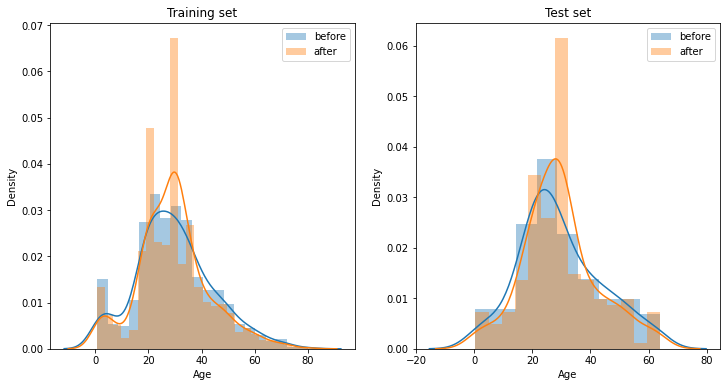

In [19]:
# Impute test set
x_tr = X_train.copy()
x_ts = X_test.copy()


# Impute training set
print('Missing ages before imputation:')
print('Train: {}\nTest:  {}\n'.format(X_train['Age'].isna().sum(), X_test['Age'].isna().sum()))
X_train['Age'] = X_train.groupby('title')['Age'].apply(lambda x: x.fillna(x.median()))


x_tr['set'] = 'train'
x_ts['set'] = 'test'

all_df = pd.concat([x_tr, x_ts])

X_test = all_df.groupby('title').apply(lambda x: x[x['set'] == 'test'].fillna(x[x['set'] == 'train'].median())).drop(['Survived','set'], axis=1).reset_index(drop=True)


print('Missing ages after imputation:')
print('Train: {}\nTest:  {}\n'.format(X_train['Age'].isna().sum(), X_test['Age'].isna().sum()))


plt.figure(figsize=(12, 6))
ax = plt.subplot(121)
sns.distplot(x_tr['Age'], label='before', ax=ax)
sns.distplot(X_train['Age'], label='after', ax=ax)
ax.legend()
ax.set_title('Training set')

ax = plt.subplot(122)
sns.distplot(x_ts['Age'], label='before', ax=ax)
sns.distplot(X_test['Age'], label='after', ax=ax)
ax.legend()
ax.set_title('Test set')


X_train.drop('title', axis=1, inplace=True)
X_test.drop('title', axis=1, inplace=True)

del all_df

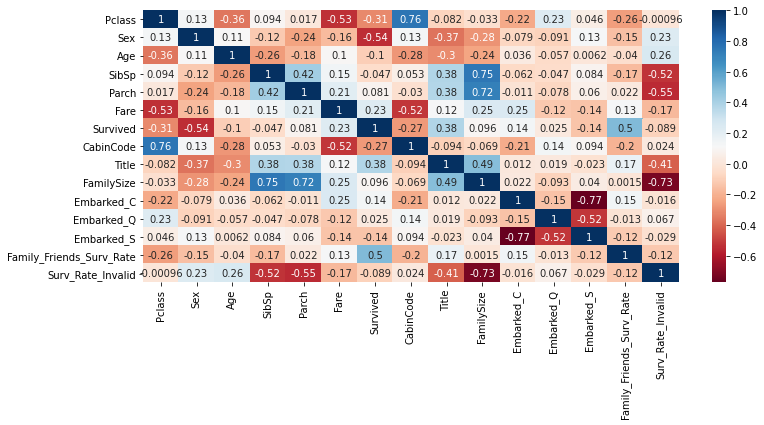

In [20]:
# Feature correlations
plt.subplots(figsize = (12,5))
sns.heatmap(X_train.corr(), cmap = 'RdBu', cbar = True, annot = True)
plt.show()

In [21]:
X_train.drop(['SibSp', 'Parch', 'Surv_Rate_Invalid'], axis=1, inplace=True)
X_test.drop(['SibSp', 'Parch', 'Surv_Rate_Invalid'], axis=1, inplace=True)

In [22]:
X_tr, X_ts = X_train.copy(), X_test.copy()

In [23]:
X_train = X_train.drop(columns = ['Survived'])

scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [24]:
# model building

params = {'n_neighbors': range(2, 201),
          'weights': ['uniform', 'distance'],
          'metric': ['minkowski'],
          'p': [1,2,3,4]
          }

scoring = {'Accuracy': make_scorer(accuracy_score),
           'Precision': make_scorer(precision_score),
           'Recall': make_scorer(recall_score),
           'F1': make_scorer(f1_score),
           }


clf = KNeighborsClassifier()

grid = GridSearchCV(clf, 
                    param_grid=params,
                    cv=5,
                    scoring=scoring, 
                    refit='F1', 
                    return_train_score=True,
                    verbose=1,
                    n_jobs=-1)
grid.fit(X_train, y_train)

print(grid.best_score_)
print(grid.best_estimator_)

Fitting 5 folds for each of 1592 candidates, totalling 7960 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 332 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done 832 tasks      | elapsed:   35.8s
[Parallel(n_jobs=-1)]: Done 1532 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 2432 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 3532 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 4832 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done 6332 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done 7482 tasks      | elapsed:  6.2min
0.8134791189202953
KNeighborsClassifier(n_neighbors=28, p=3)
[Parallel(n_jobs=-1)]: Done 7960 out of 7960 | elapsed:  6.6min finished


In [25]:
resultsDF=pd.DataFrame(grid.cv_results_)

distance = {1: 'Manhattan', 2: 'Euclidean', 3: 'Minkowski of power 3', 4: 'Minkowski of power 4'}

for weights, p in product(['uniform', 'distance'], [1,2,3,4]):
    print(f'Best F1 results for KNN classifier with {weights} weights and {distance[p]} distance.')
    # find optimal number of neighbors for that combination of values
    neighbors = resultsDF.loc[(resultsDF.param_weights==weights) & (resultsDF.param_p==p)].sort_values('mean_test_F1', ascending=False).iloc[0]['param_n_neighbors']
    print(f'Best results after 5-fold CV are obtained through a model with {neighbors} neighbors.')
    # train a model and return the metrics on test set 
    classifier = KNeighborsClassifier(n_neighbors=neighbors, weights=weights, metric='minkowski', p=p)
    classifier.fit(X_train, y_train)
    preds = classifier.predict(X_test)
    print('Classification report:')
    print(classification_report(y_test, preds), '\n')

Best F1 results for KNN classifier with uniform weights and Manhattan distance.
Best results after 5-fold CV are obtained through a model with 15 neighbors.
Classification report:
              precision    recall  f1-score   support

           0       0.63      0.69      0.66       110
           1       0.41      0.35      0.38        69

    accuracy                           0.56       179
   macro avg       0.52      0.52      0.52       179
weighted avg       0.55      0.56      0.55       179
 

Best F1 results for KNN classifier with uniform weights and Euclidean distance.
Best results after 5-fold CV are obtained through a model with 11 neighbors.
Classification report:
              precision    recall  f1-score   support

           0       0.63      0.66      0.65       110
           1       0.42      0.39      0.41        69

    accuracy                           0.56       179
   macro avg       0.53      0.53      0.53       179
weighted avg       0.55      0.56      

### F1 score for KNN classifier models with different values of neighboors

Age handling in two different ways   

 1. Median value of age for each title
 2. Droping age feature

In [26]:
X_tr.drop(columns=['Survived', 'Age'], inplace=True)
X_ts.drop(columns=['Age'], inplace=True)

scaler = StandardScaler()
scaler.fit(X_tr)
X_tr = scaler.transform(X_tr)
X_ts = scaler.transform(X_ts)

In [27]:
neighbors = range(1, 201)
weight = 'uniform'
p = 2

age_f1, no_age_f1 = [], []

for neighbor in neighbors:
    classifier = KNeighborsClassifier(n_neighbors=neighbor, weights=weight, metric='minkowski', p=p)
    classifier.fit(X_train, y_train)
    preds = classifier.predict(X_test)
    age_f1 += [f1_score(y_test, preds)]

    classifier = KNeighborsClassifier(n_neighbors=neighbor, weights=weight, metric='minkowski', p=p)
    classifier.fit(X_tr, y_train)
    preds = classifier.predict(X_ts)
    no_age_f1 += [f1_score(y_test, preds)]

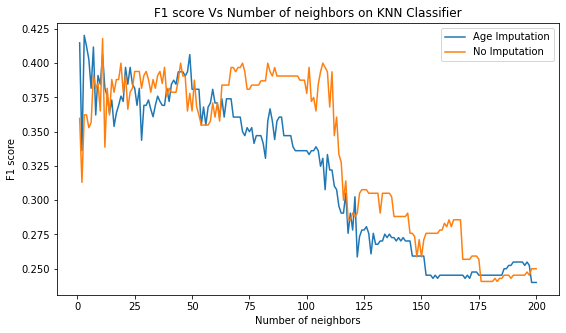

In [28]:
plt.figure(figsize=(9,5))
plt.plot(range(1,201), age_f1, label='Age Imputation')
plt.plot(range(1,201), no_age_f1, label='No Imputation')
plt.xlabel('Number of neighbors')
plt.ylabel('F1 score')
plt.title('F1 score Vs Number of neighbors on KNN Classifier')
plt.legend(loc='upper right')
plt.show()